In [1]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import jax.random as random
from functools import partial
from typing import Callable, Union
from collections import namedtuple
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import dill

from kernel import imq_kernel, rbf_kernel
from model import model
from methods import VGD
from experiment import experiment, diagnostic_experiment
from calculate_mmd import calculate_mmd_squared
from plot_functions import plot_predictives, plot_main_figure, plot_KGD, plot_kde_q, plot_kde_q_2d


def quadratic_reg(theta, x):
    return theta * x**2

quad_model = model(0.5, quadratic_reg, theta_dim=1)

def my_sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def sigmoid_reg(theta, x):
    return 1 / (1 + jnp.exp(-theta * x))

sig_model = model(0.05, sigmoid_reg, theta_dim=1)

def linear_reg(theta, x):
    return theta[0] + theta[1] * x

linear_model = model(0.8, linear_reg, theta_dim=2)

d:\OneDrive - Newcastle University\Project_3_refactor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data_quad_w = quad_model.generate_data(1000, 5, x_min=0.0, x_max=1.0, key=random.PRNGKey(12))
data_sig_w = sig_model.generate_data(1000, 5, x_min=-1.0, x_max=1.0, key=random.PRNGKey(34))

key = random.PRNGKey(12)
rng, key = random.split(key)
n_data = 1000
xs = random.uniform(rng, (n_data,))
true_theta = 5.
sigma = 0.5
phi = 3
rng, key = random.split(key)
ys = (true_theta + phi * random.normal(rng, xs.shape)) * jnp.square(xs)
rng, key = random.split(key)
ys += sigma * random.normal(rng, xs.shape)
data_quad_m = (xs, ys)

def sigmoid(z):
  return 1 / (1 + jnp.exp(-z))
key = jax.random.PRNGKey(42) 
n_data = 1000
key, x_key = random.split(key)
x = random.uniform(x_key, (n_data,), minval=-1.0, maxval=1.0)
key, y_neg_key, y_pos_key = random.split(key, 3)
y_neg = random.uniform(y_neg_key, (n_data,), minval=0.0, maxval=0.5)
y_pos = random.uniform(y_pos_key, (n_data,), minval=0.5, maxval=1.0)
y_observed = jnp.where(x < 0, y_neg, y_pos)
data_sig_m = (x, y_observed)


true_theta = jnp.array([5.0, 3.0]) 
prior_mean = jnp.array([0.0, 0.0])
key = random.PRNGKey(12)
rng, key = random.split(key)
n_data = 1000
xs = random.uniform(rng, (n_data,), minval=-2.0, maxval=2.0)
sigma = 0.8
rng, key = random.split(key)
ys = true_theta[0] + true_theta[1] * xs
ys += sigma * random.normal(rng, xs.shape)
data_linear_w = (xs, ys)

true_theta = jnp.array([5.0, 3.0]) 
prior_mean = jnp.array([0.0, 0.0])
key = random.PRNGKey(12)
rng, key = random.split(key)
n_data = 1000
xs = random.uniform(rng, (n_data,), minval=-2.0, maxval=2.0) 
sigma = 0.8 
rng, key = random.split(key)
ys = true_theta[0] + true_theta[1] * xs + 2 * jnp.square(xs)
ys += sigma * random.normal(rng, xs.shape)
data_linear_m = (xs, ys)

## quad

In [3]:
experiment_quad_w = experiment(quad_model, data_quad_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
# experiment_quad_w.run(n_steps=5000, step_size=0.001, lengthscale=0.1)
experiment_quad_w.run(n_steps=5000, step_size=0.001)

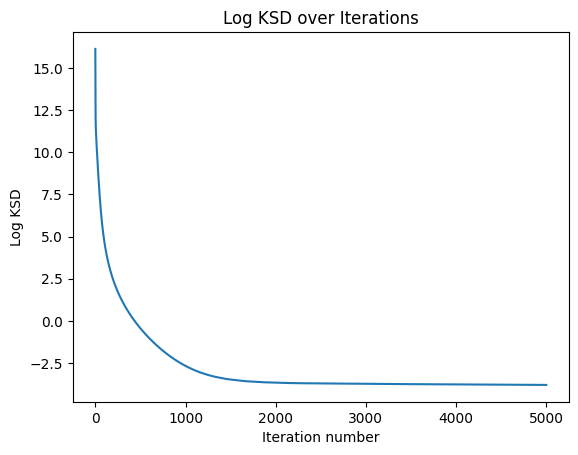

In [4]:
experiment_quad_w.plot_KSD()

MMD length scale: 1.4647671
Actual mmd 6.911791e-06


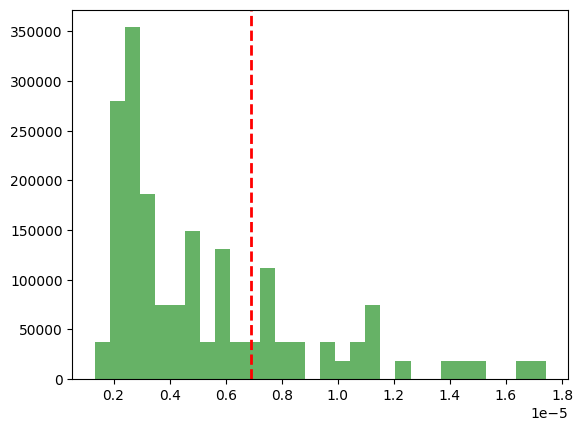

In [5]:
diagnostic_experiment_quad_w = diagnostic_experiment(experiment_quad_w)
all_mmd_values_quad_w, actual_mmd_quad_w = diagnostic_experiment_quad_w.plot_diagnostic()

In [6]:
experiment_quad_m = experiment(quad_model, data_quad_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_quad_m.run(n_steps=5000, step_size=0.0005, lengthscale=0.1)

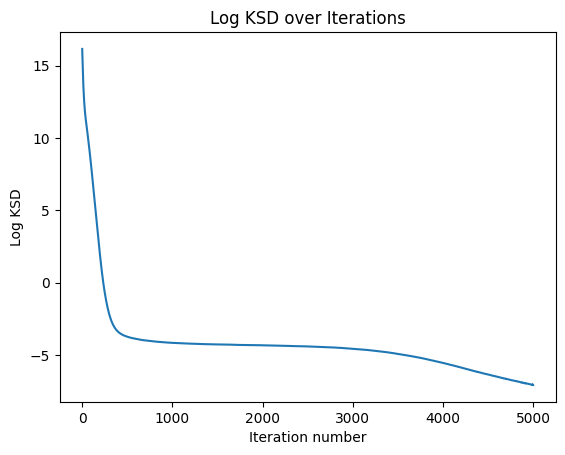

In [7]:
experiment_quad_m.plot_KSD()

MMD length scale: 1.8091974
Actual mmd 0.0006505056


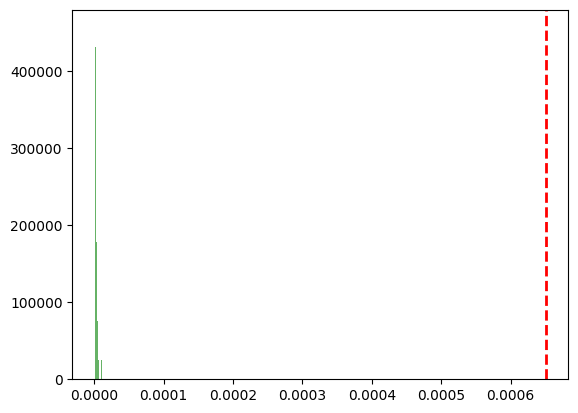

In [8]:
diagnostic_experiment_quad_m = diagnostic_experiment(experiment_quad_m)
all_mmd_values_quad_m, actual_mmd_quad_m = diagnostic_experiment_quad_m.plot_diagnostic()

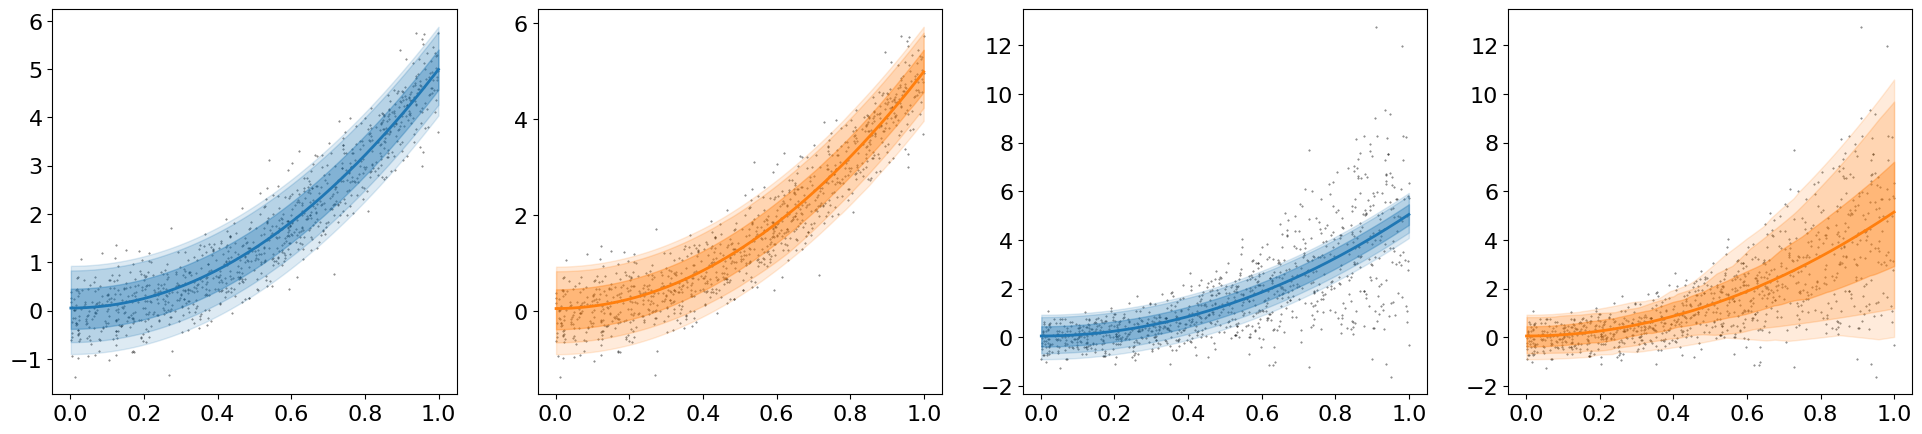

In [9]:
plot_predictives(experiment_quad_w, experiment_quad_m)

## sigmoid

In [10]:
experiment_sig_w = experiment(sig_model, data_sig_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
# experiment_sig_w.run(n_steps=10000, step_size=0.001, lengthscale=0.1)
experiment_sig_w.run(n_steps=10000, step_size=0.005)

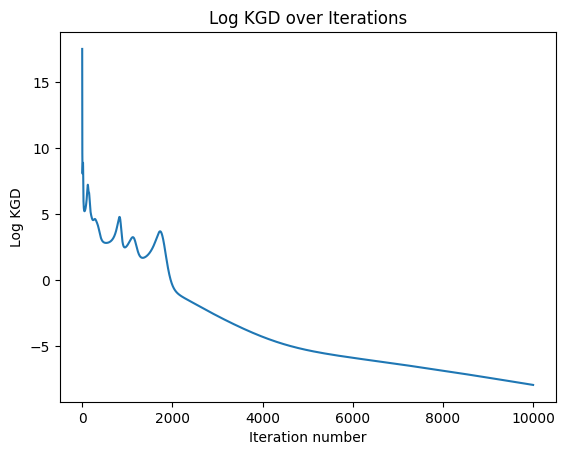

In [17]:
experiment_sig_w.plot_KGD()

In [18]:
experiment_sig_w.particles_VGD.mean(axis=0)

Array([5.0130777], dtype=float32)

MMD length scale: 0.39202625
Actual mmd 9.0697864e-07


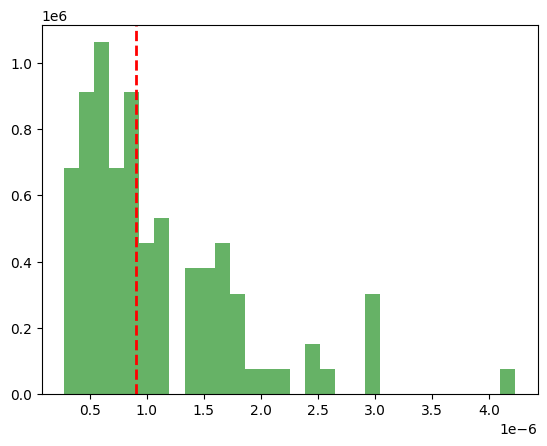

In [20]:
diagnostic_experiment_sig_w = diagnostic_experiment(experiment_sig_w)
all_mmd_values_sig_w, actual_mmd_sig_w = diagnostic_experiment_sig_w.plot_diagnostic()

In [11]:
experiment_sig_m = experiment(sig_model, data_sig_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_sig_m.run(n_steps=5000, step_size=0.0005, lengthscale=0.1)

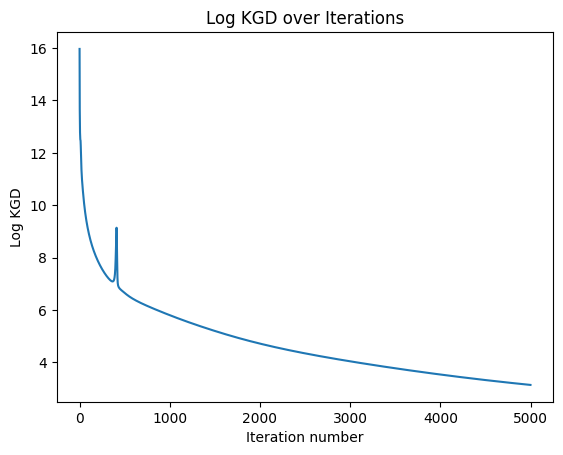

In [25]:
experiment_sig_m.plot_KGD()

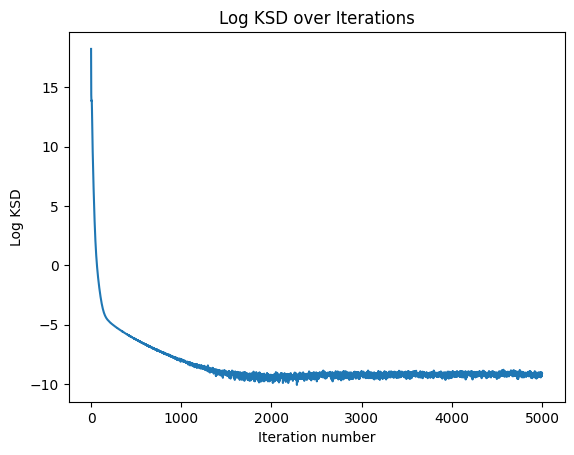

In [26]:
experiment_sig_m.plot_KSD()

MMD length scale: 0.2725378
Actual mmd 0.0007276071


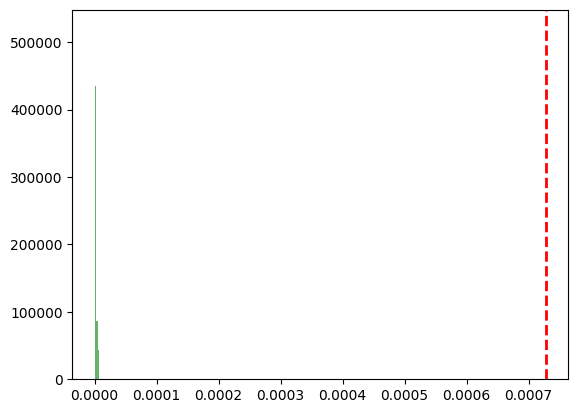

In [24]:
diagnostic_experiment_sig_m = diagnostic_experiment(experiment_sig_m)
all_mmd_values_sig_m, actual_mmd_sig_m = diagnostic_experiment_sig_m.plot_diagnostic()

In [13]:
experiment_sig_m.particles_VGD

Array([[ 2.3247998 ],
       [-2.3467364 ],
       [ 1.4567698 ],
       [ 1.2550759 ],
       [ 3.078563  ],
       [ 0.3585945 ],
       [11.807421  ],
       [39.001938  ],
       [ 2.6139297 ],
       [ 6.062084  ],
       [ 1.9453908 ],
       [ 4.5181327 ],
       [14.024859  ],
       [ 0.8124425 ],
       [ 0.3228778 ],
       [ 4.833005  ],
       [ 1.0018047 ],
       [ 0.40202603],
       [ 4.2442045 ],
       [ 1.6751366 ]], dtype=float32)

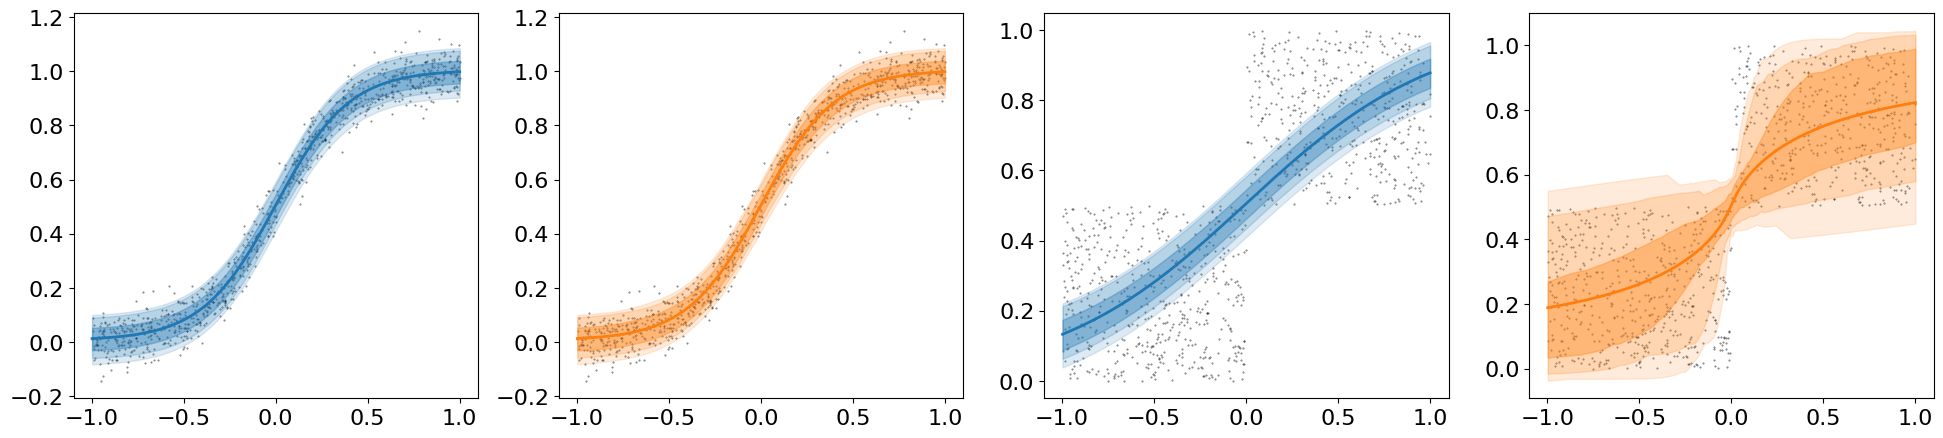

In [12]:
plot_predictives(experiment_sig_w, experiment_sig_m)

## linear and quadratic

In [14]:
experiment_landq_w = experiment(linear_model, data_linear_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
# experiment_landq_w.run(n_steps=10000, step_size=0.0005, lengthscale=0.1)
experiment_landq_w.run(n_steps=10000, step_size=0.0005)

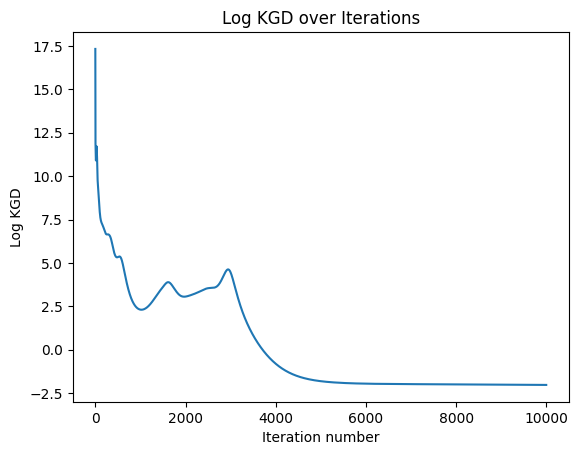

In [18]:
experiment_landq_w.plot_KGD()

MMD length scale: 3.4559252
Actual mmd 6.077099e-06


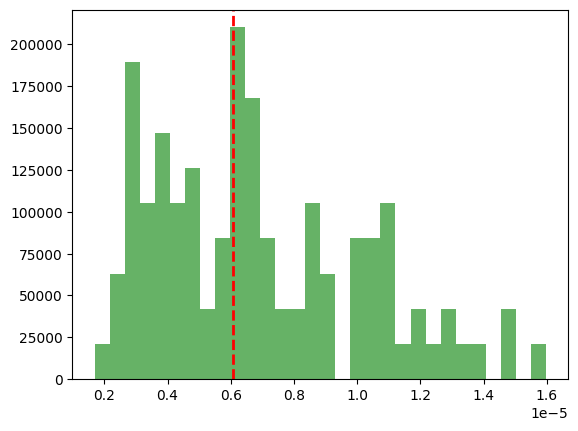

In [15]:
diagnostic_experiment_landq_w = diagnostic_experiment(experiment_landq_w)
all_mmd_values_landq_w, actual_mmd_landq_w = diagnostic_experiment_landq_w.plot_diagnostic()

In [16]:
experiment_landq_m = experiment(linear_model, data_linear_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
# experiment_landq_m.run(n_steps=10000, step_size=0.0005, lengthscale=0.1)
experiment_landq_m.run(n_steps=10000, step_size=0.0005)

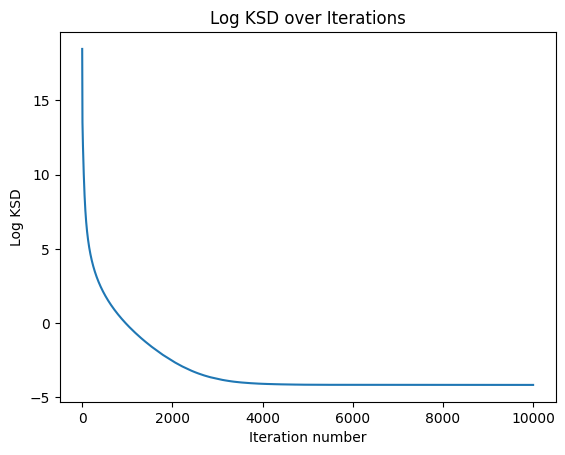

In [17]:
experiment_landq_m.plot_KSD()

MMD length scale: 4.900139
Actual mmd 0.001480315


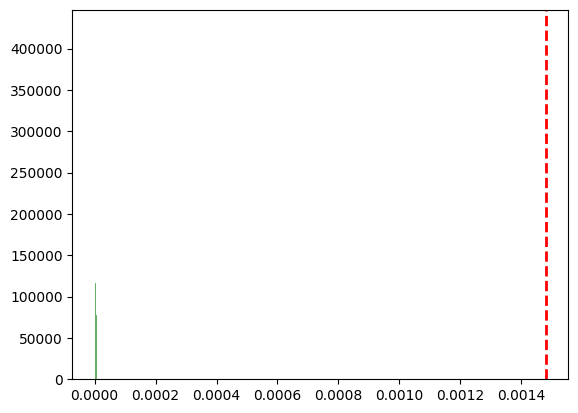

In [21]:
diagnostic_experiment_landq_m = diagnostic_experiment(experiment_landq_m)
all_mmd_values_landq_m, actual_mmd_landq_m = diagnostic_experiment_landq_m.plot_diagnostic()

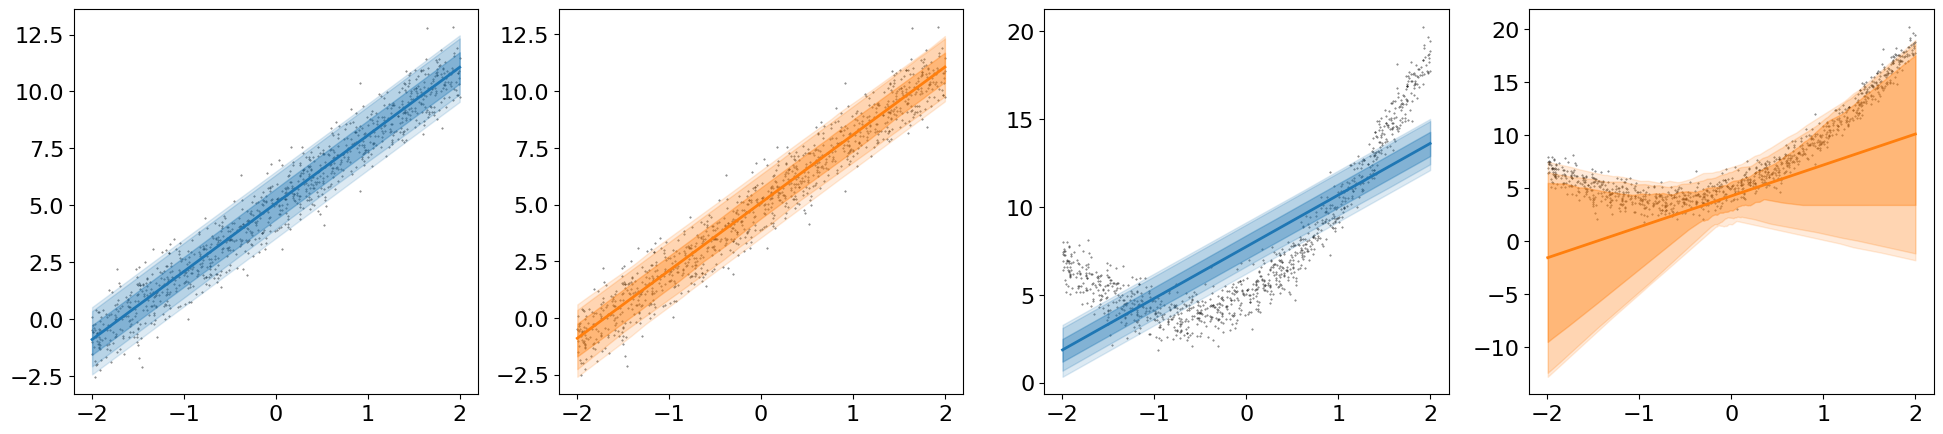

In [19]:
plot_predictives(experiment_landq_w, experiment_landq_m)

In [ ]:
data_to_save = {
    'experiment_quad_w': experiment_quad_w,
    'experiment_quad_m': experiment_quad_m,
    'all_mmd_values_quad_w': all_mmd_values_quad_w,
    'actual_mmd_quad_w': actual_mmd_quad_w,
    'all_mmd_values_quad_m': all_mmd_values_quad_m,
    'actual_mmd_quad_m': actual_mmd_quad_m,
    'experiment_sig_w': experiment_sig_w,
    'experiment_sig_m': experiment_sig_m,
    'all_mmd_values_sig_w': all_mmd_values_sig_w,
    'actual_mmd_sig_w': actual_mmd_sig_w,
    'all_mmd_values_sig_m': all_mmd_values_sig_m,
    'actual_mmd_sig_m': actual_mmd_sig_m,
    'experiment_landq_w': experiment_landq_w,
    'experiment_landq_m': experiment_landq_m,
    'all_mmd_values_landq_w': all_mmd_values_landq_w,
    'actual_mmd_landq_w': actual_mmd_landq_w,
    'all_mmd_values_landq_m': all_mmd_values_landq_m,
    'actual_mmd_landq_m': actual_mmd_landq_m
}
import dill
with open('main_fig.dill', 'wb') as f:
    dill.dump(data_to_save, f)

In [25]:
try:
    with open('main_fig.dill', 'rb') as f:
        data_to_save = dill.load(f)
    print("加载成功：旧的字典已读入内存。")
except FileNotFoundError:
    print("警告：未找到旧文件。将创建一个新的字典。")
    data_to_save = {}

data_to_save = {
    'experiment_quad_w': experiment_quad_w,
    'experiment_quad_m': experiment_quad_m,
    'all_mmd_values_quad_w': all_mmd_values_quad_w,
    'actual_mmd_quad_w': actual_mmd_quad_w,
    'all_mmd_values_quad_m': all_mmd_values_quad_m,
    'actual_mmd_quad_m': actual_mmd_quad_m,
    'experiment_sig_w': experiment_sig_w,
    'experiment_sig_m': experiment_sig_m,
    'all_mmd_values_sig_w': all_mmd_values_sig_w,
    'actual_mmd_sig_w': actual_mmd_sig_w,
    'all_mmd_values_sig_m': all_mmd_values_sig_m,
    'actual_mmd_sig_m': actual_mmd_sig_m,
    'experiment_landq_w': experiment_landq_w,
    'experiment_landq_m': experiment_landq_m,
    'all_mmd_values_landq_w': all_mmd_values_landq_w,
    'actual_mmd_landq_w': actual_mmd_landq_w,
    'all_mmd_values_landq_m': all_mmd_values_landq_m,
    'actual_mmd_landq_m': actual_mmd_landq_m
}
with open('main_fig.dill', 'wb') as f:
    dill.dump(data_to_save, f)

加载成功：旧的字典已读入内存。


In [6]:
with open('main_fig.dill', 'rb') as f:
    loaded_data = dill.load(f)

d:\OneDrive - Newcastle University\Project_3_refactor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
loaded_data.keys()

dict_keys(['experiment_quad_w', 'experiment_quad_m', 'all_mmd_values_quad_w', 'actual_mmd_quad_w', 'all_mmd_values_quad_m', 'actual_mmd_quad_m', 'experiment_sig_w', 'experiment_sig_m', 'all_mmd_values_sig_w', 'actual_mmd_sig_w', 'all_mmd_values_sig_m', 'actual_mmd_sig_m', 'experiment_landq_w', 'experiment_landq_m', 'all_mmd_values_landq_w', 'actual_mmd_landq_w', 'all_mmd_values_landq_m', 'actual_mmd_landq_m'])

## main figure

成功加载文件，包含 18 个数组: ['experiment_quad_w', 'experiment_quad_m', 'all_mmd_values_quad_w', 'actual_mmd_quad_w', 'all_mmd_values_quad_m', 'actual_mmd_quad_m', 'experiment_sig_w', 'experiment_sig_m', 'all_mmd_values_sig_w', 'actual_mmd_sig_w', 'all_mmd_values_sig_m', 'actual_mmd_sig_m', 'experiment_landq_w', 'experiment_landq_m', 'all_mmd_values_landq_w', 'actual_mmd_landq_w', 'all_mmd_values_landq_m', 'actual_mmd_landq_m']
Actual mmd 6.133032002253458e-06
Actual mmd 0.000650508445687592
Actual mmd 8.393983534915606e-07
Actual mmd 0.0007276084506884217
Actual mmd 5.43872647540411e-06
Actual mmd 0.0017381410580128431


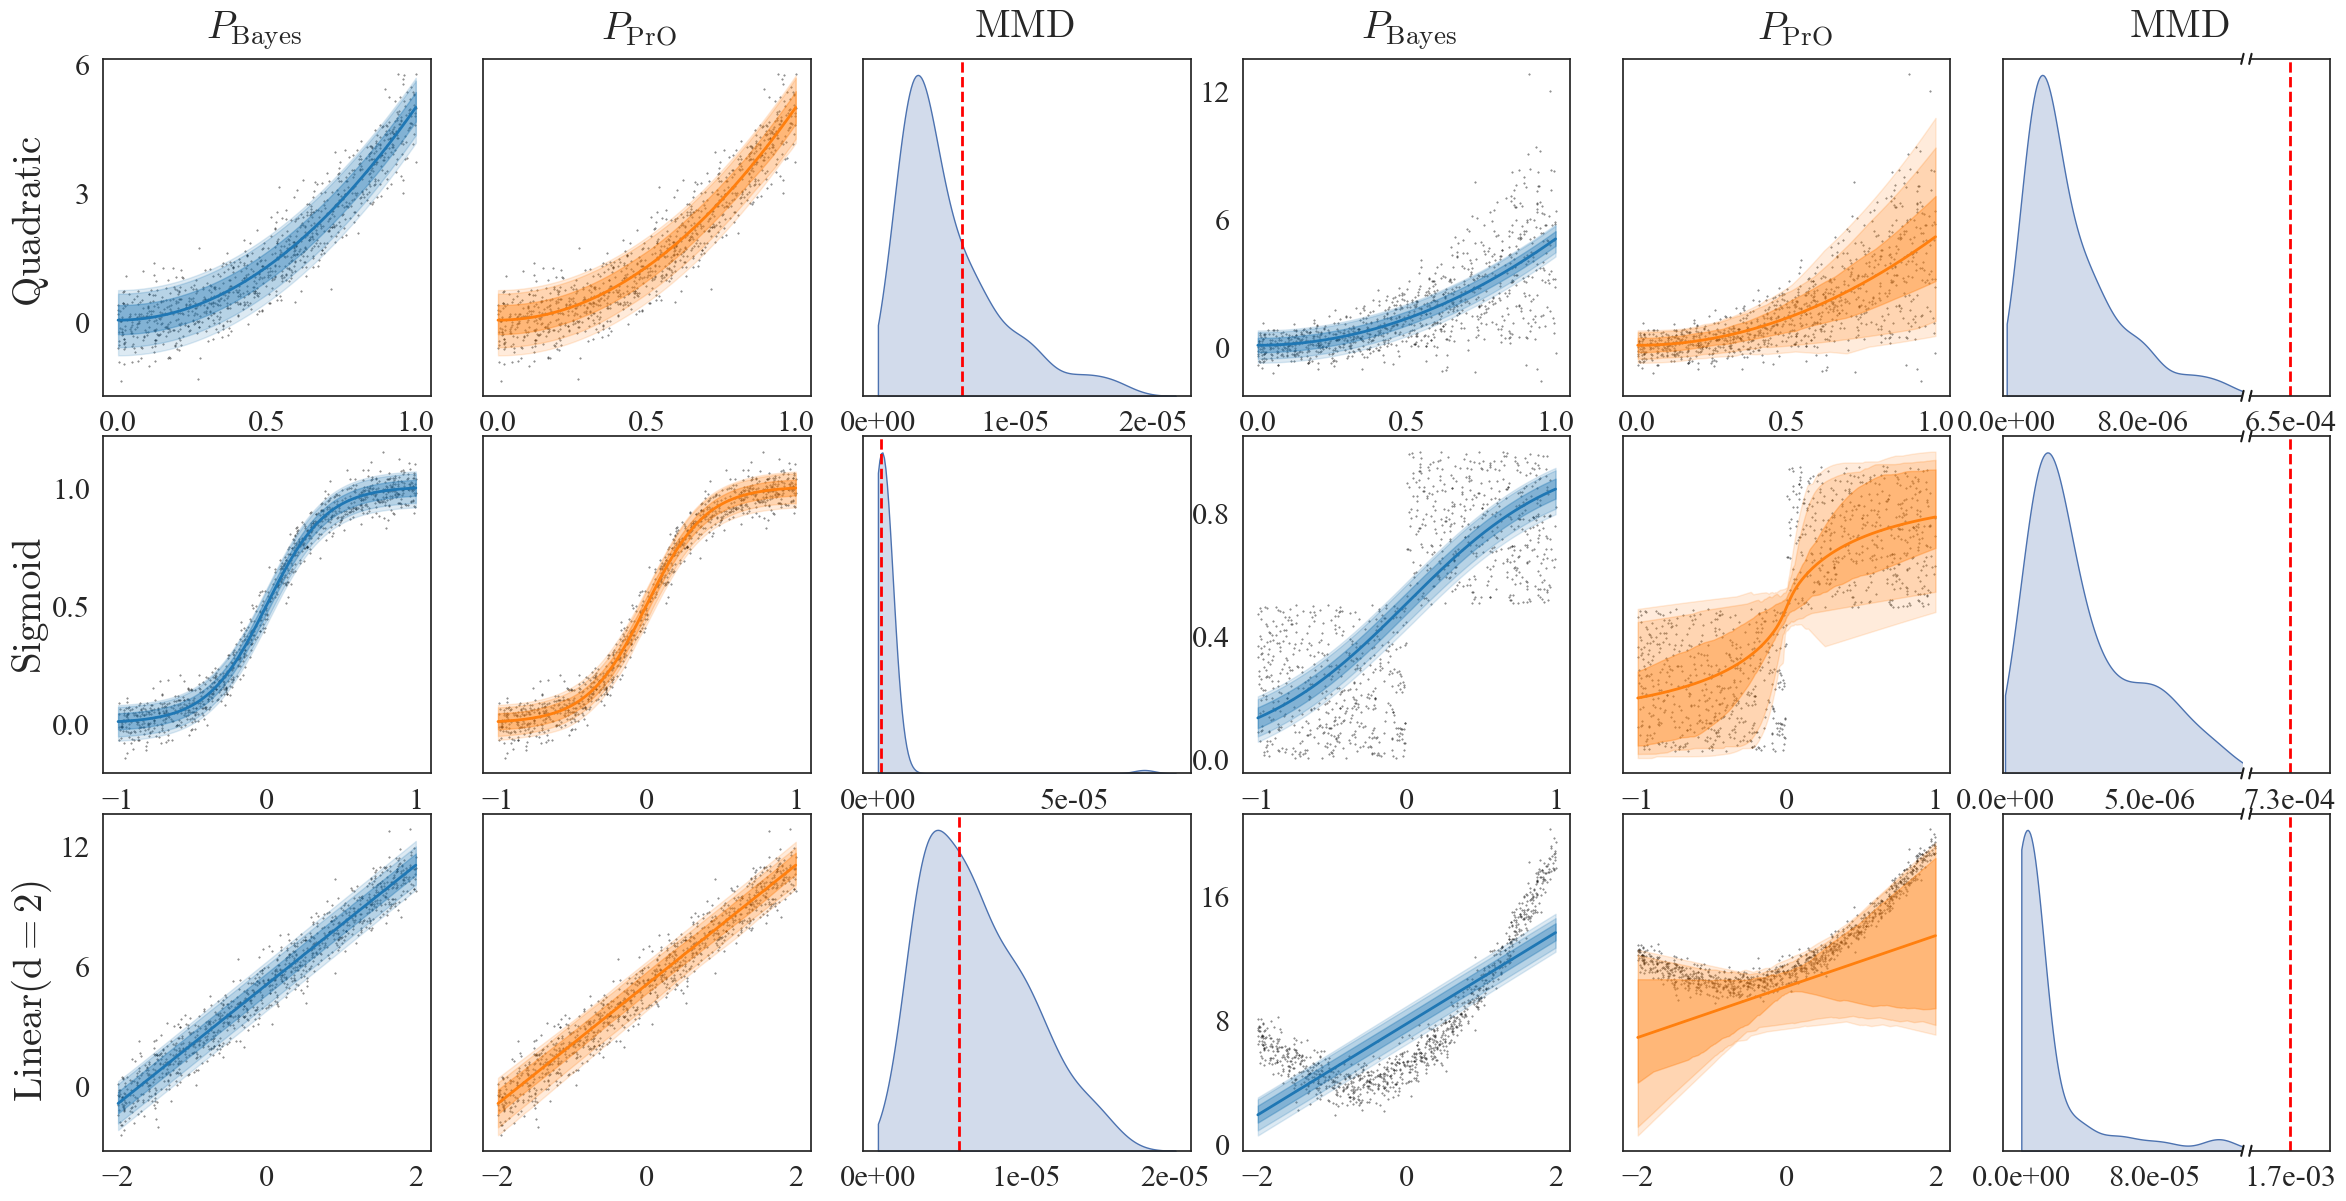

In [2]:
plot_main_figure('main_fig.dill')

## trajectory figure

In [14]:
def plot_trajectory_2d(particle_history, true_theta, n_paths_to_plot=20, 
                         base_color='orange', gradient_color=True, ax=None):

    particle_history_np = np.array(particle_history)
    true_theta_np = np.array(true_theta)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        show_plot = True
    else:
        show_plot = False # 如果在指定的ax上画，则由外部代码决定何时显示

    sns.set_theme(style="whitegrid")
    
    # take out the trajectories to plot
    paths = particle_history_np[:, :n_paths_to_plot, :]

    # gradient colour option
    if gradient_color:
        colors = sns.light_palette(base_color, n_colors=n_paths_to_plot)
    else:
        colors = [base_color] * n_paths_to_plot

    # plot each trajectory
    for i in range(n_paths_to_plot):
        ax.plot(paths[:, i, 0], paths[:, i, 1], color=colors[i], alpha=0.7, linewidth=1.5)

    # final points
    ax.scatter(paths[-1, :, 0], paths[-1, :, 1], 
               c=colors, s=50, zorder=5,
               edgecolor='black', linewidth=0.5, label='Final Positions')

    # starting points
    ax.scatter(paths[0, :, 0], paths[0, :, 1], 
               facecolors='none', edgecolors=colors, s=50, zorder=5,
               linewidth=1.5, label='Start Positions')
    
    ## true parameter position
    # ax.scatter(true_theta_np[0], true_theta_np[1], c='red', s=100, marker='*', zorder=6, label='True Value')

    ax.set_xlabel(r'$\theta_1$', fontsize=20)
    ax.set_ylabel(r'$\theta_2$', fontsize=20)
    # ax.set_title(f'2D Particle Trajectories')
    # ax.legend()
    ax.axis('equal')

    if show_plot:
        plt.show()


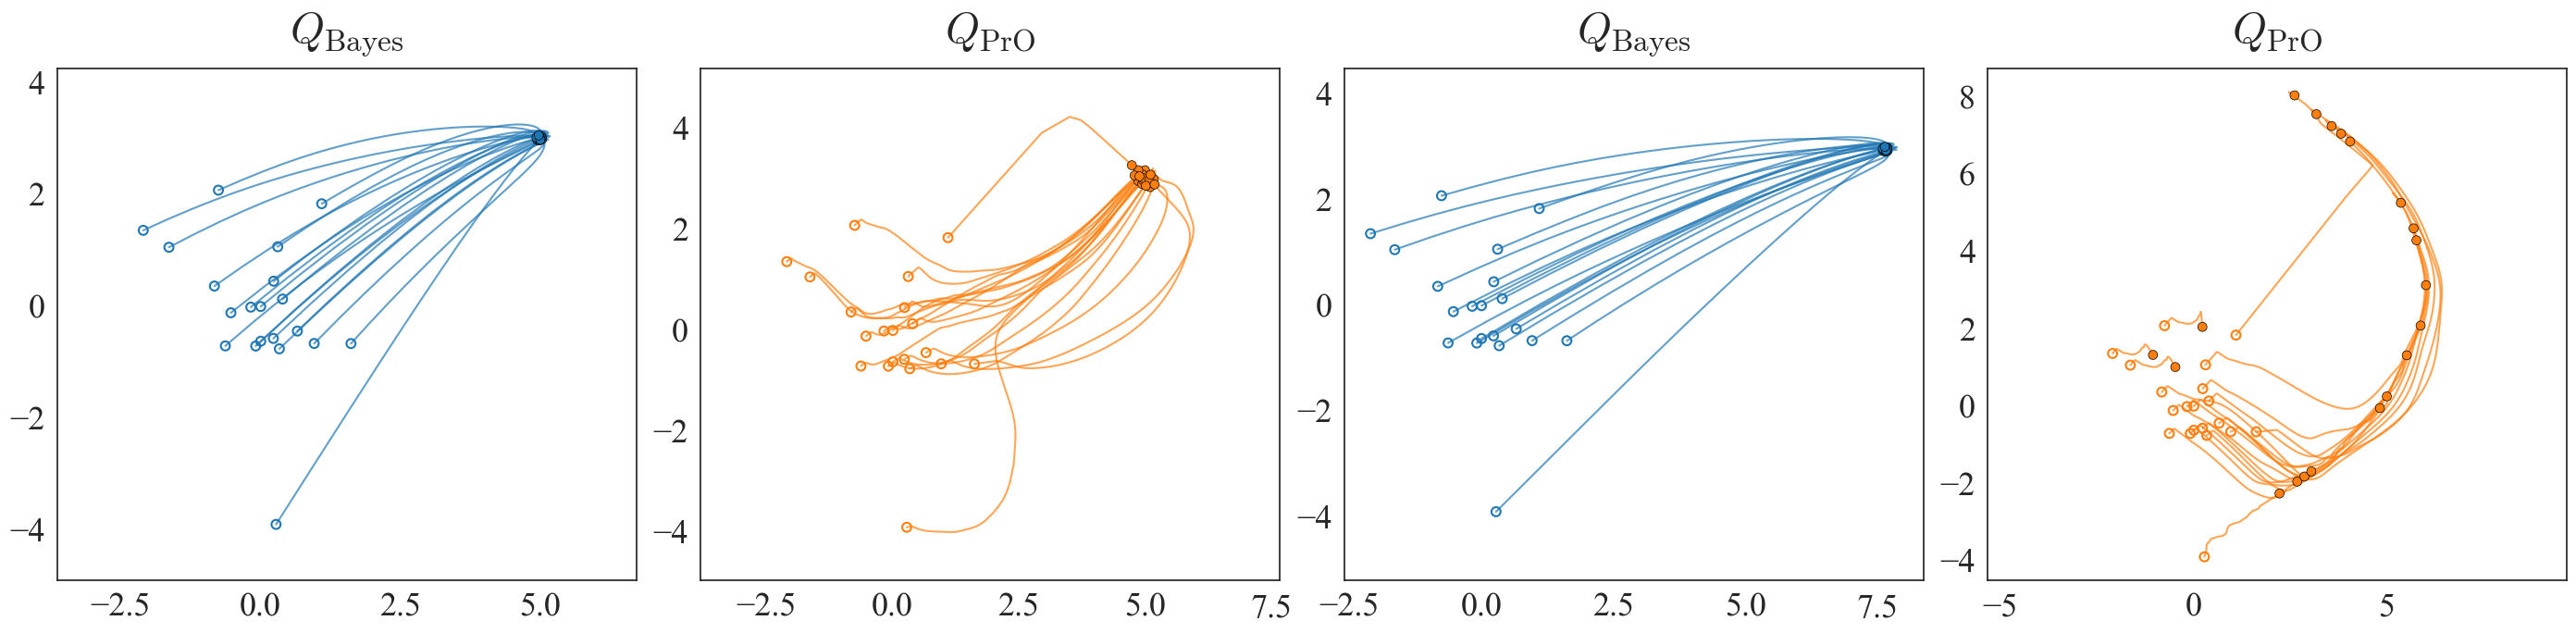

In [19]:
with open('main_fig.dill', 'rb') as f:
    data = dill.load(f)

sns.set_theme(
    style="white",
    rc={
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman", "CMU Serif", "Times New Roman"],
        "mathtext.fontset": "cm",
        "legend.frameon": True
    }
    )

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 7))
VGD_color = '#ff7f0e'
SVGD_color = '#1f77b4'
true_theta = jnp.array([5.0, 3.0])

plot_trajectory_2d(data['experiment_landq_w'].history_SVGD, true_theta, n_paths_to_plot=20, 
                     base_color=SVGD_color, gradient_color=False, ax=axes[0])
axes[0].set_title(r'$Q_\mathrm{Bayes}$', fontsize=34, pad=20) 

plot_trajectory_2d(data['experiment_landq_w'].history_VGD, true_theta, n_paths_to_plot=20, 
                     base_color=VGD_color, gradient_color=False, ax=axes[1])
axes[1].set_title( r'$Q_{\mathrm{PrO}}$', fontsize=34, pad=20)
plot_trajectory_2d(data['experiment_landq_m'].history_SVGD, true_theta, n_paths_to_plot=20, 
                     base_color=SVGD_color, gradient_color=False, ax=axes[2])
axes[2].set_title(r'$Q_\mathrm{Bayes}$', fontsize=34, pad=20)

plot_trajectory_2d(data['experiment_landq_m'].history_VGD, true_theta, n_paths_to_plot=20, 
                     base_color=VGD_color, gradient_color=False, ax=axes[3])
axes[3].set_title(r'$Q_{\mathrm{PrO}}$', fontsize=34, pad=20)

for ax in axes:
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis='both', which='major', labelsize=26)
# fig.suptitle('Comparison of Trajectory Plotting Styles', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 1]) # rect为总标题留出空间
plt.show()

In [2]:
with open('main_fig.dill', 'rb') as f:
    data = dill.load(f)


In [8]:
data['experiment_landq_w'].particles_SVGD.mean(axis=0)

Array([4.9925795, 2.9945946], dtype=float32)

## posteriors and KGDs figure

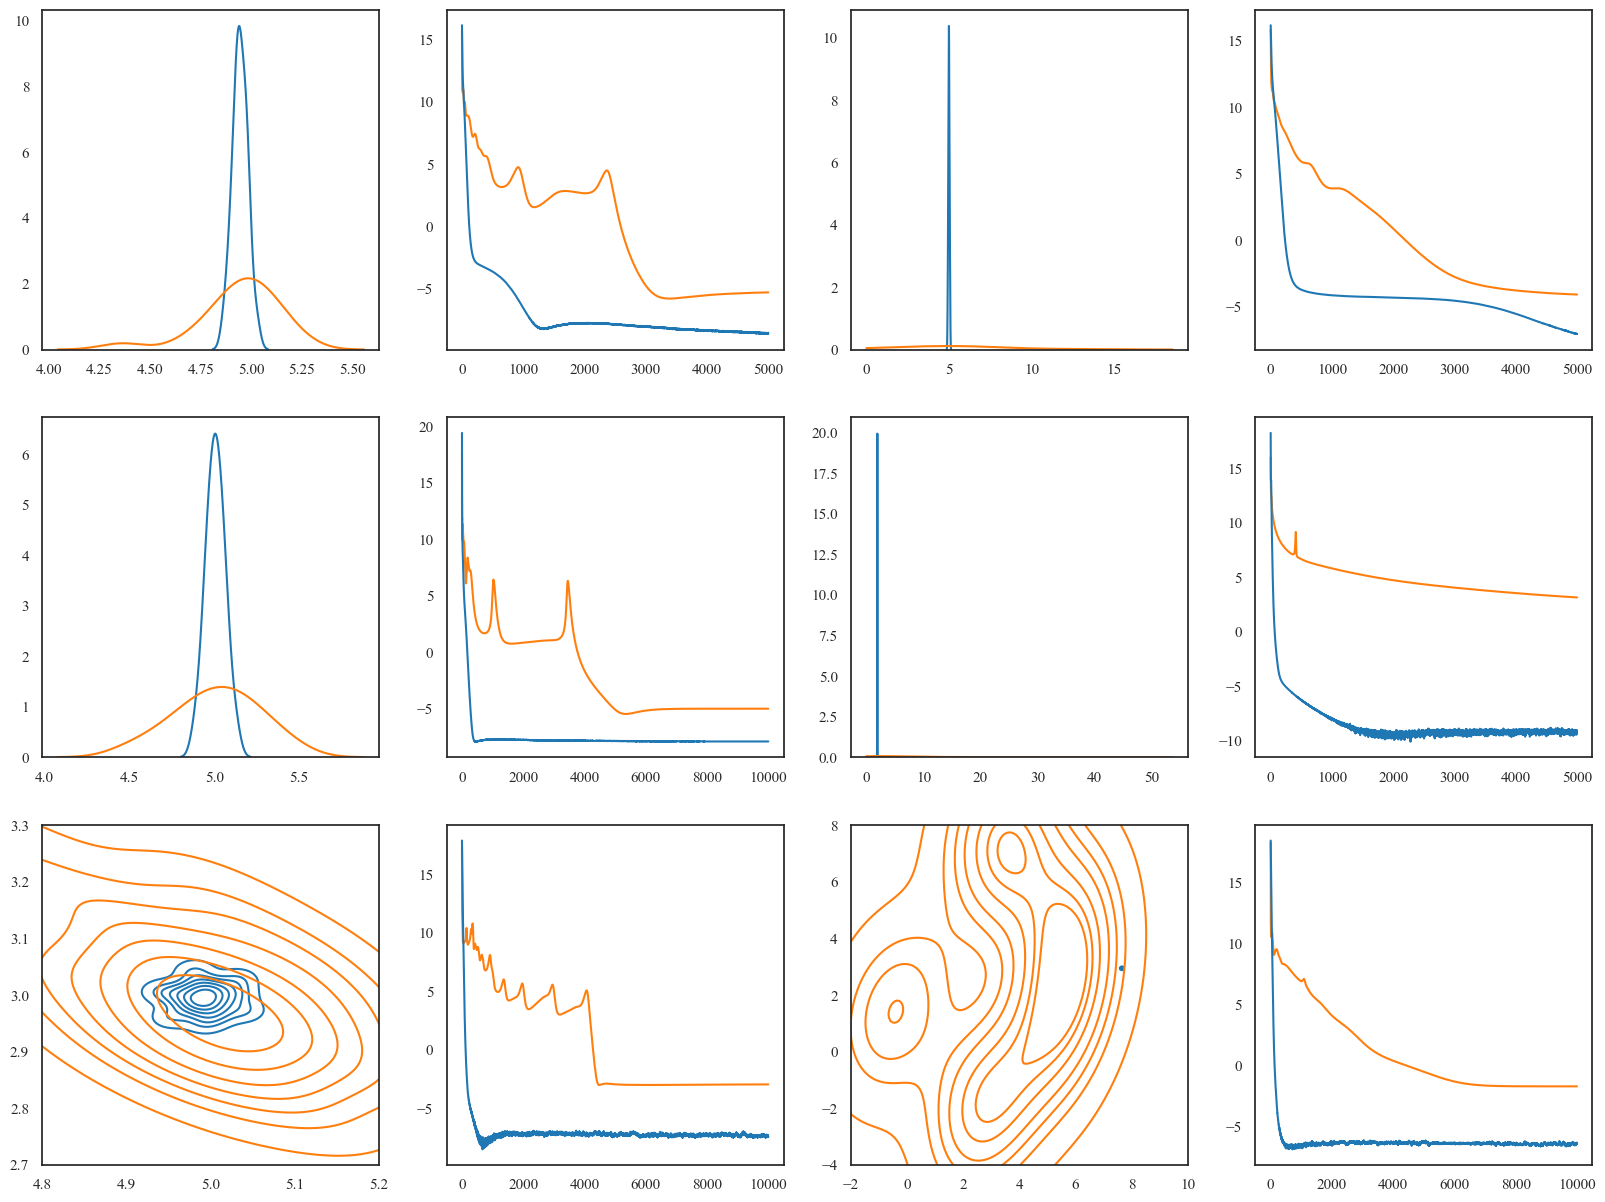

In [23]:
VGD_colour = '#ff7f0e'
SVGD_colour = '#1f77b4'

def plot_KGD(ax, experiment: experiment):
    ax.plot(range(len(experiment.history_KGD)), jnp.log(experiment.history_KGD), label='Log KGD', color=VGD_colour)
    ax.plot(range(len(experiment.history_KSD)), jnp.log(experiment.history_KSD), label='Log KSD', color=SVGD_colour)
    ax.set(xlabel=None, ylabel=None)


def plot_kde_q(ax, experiment: experiment):
    sns.kdeplot(
        x=jnp.array(experiment.particles_SVGD).flatten(), 
        fill=False, 
        label='Q_Bayes', 
        clip=(0, None), 
        ax=ax, 
        color=SVGD_colour
    )
    sns.kdeplot(
        x=jnp.array(experiment.particles_VGD).flatten(), 
        fill=False, 
        label='Q_PrO', 
        clip=(0, None), 
        ax=ax, 
        color=VGD_colour
    )
    ax.set(xlabel=None, ylabel=None)
    # ax.legend()

def plot_kde_q_2d(ax, experiment: experiment, xlims=[-4,4], ylims=[-4,4], bw_adjust=1):
    x = experiment.particles_SVGD[:, 0]
    y = experiment.particles_SVGD[:, 1]
    sns.kdeplot(
        x=x, 
        y=y, 
        thresh=0.05, 
        levels=8, 
        ax=ax, 
        color=SVGD_colour,
        bw_adjust=bw_adjust,
        fill=False
    )
    x = experiment.particles_VGD[:, 0]
    y = experiment.particles_VGD[:, 1]
    sns.kdeplot(
        x=x, 
        y=y, 
        thresh=0.05, 
        levels=8, 
        ax=ax, 
        color=VGD_colour,
        bw_adjust=bw_adjust,
        fill=False
    )
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    handles = [Line2D([0], [0], color=SVGD_colour, lw=2),
                   Line2D([0], [0], color=VGD_colour, lw=2)]
    labels = [r'$Q_{Bayes}$', r'$Q_{PC}$']
    ax.set(xlabel=None, ylabel=None)

with open('main_fig.dill', 'rb') as f:
    data = dill.load(f)

sns.set_theme(
    style="white",
    rc={
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman", "CMU Serif", "Times New Roman"],
        "mathtext.fontset": "cm",
        "legend.frameon": True
    }
    )

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))


data_prefixes = ['quad', 'sig', 'landq']
row_titles = [r'$\mathrm{Quadratic}$', r'$\mathrm{Sigmoid}$', r'$\mathrm{Linear (d=2)}$']

for row_idx, prefix in enumerate(data_prefixes[0:2]):
    experiment_w = data[f'experiment_{prefix}_w']

    plot_kde_q(axes[row_idx, 0], experiment_w)
    plot_KGD(axes[row_idx, 1], experiment_w)

    experiment_m = data[f'experiment_{prefix}_m']

    plot_kde_q(axes[row_idx, 2], experiment_m)
    plot_KGD(axes[row_idx, 3], experiment_m)

experiment_w = data['experiment_landq_w']
plot_kde_q_2d(axes[2, 0], experiment_w, xlims=[4.8,5.2], ylims=[2.7,3.3])
plot_KGD(axes[2, 1], experiment_w)

experiment_m = data['experiment_landq_m']
plot_kde_q_2d(axes[2, 2], experiment_m, xlims=[-2,10], ylims=[-4,8])
plot_KGD(axes[2, 3], experiment_m)

In [1]:
data_prefixes = ['quad', 'sig', 'landq']


In [5]:
data_prefixes[0:2]

['quad', 'sig']

<Axes: >

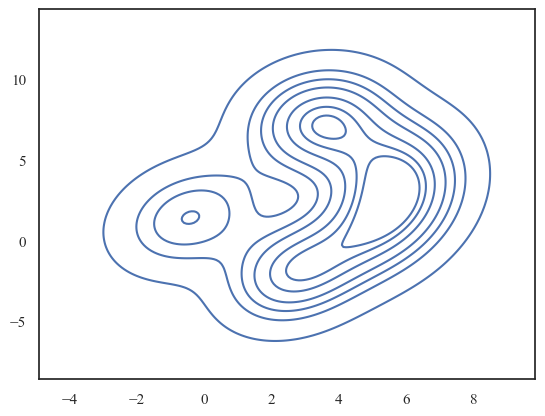

In [21]:
sns.kdeplot(x=data['experiment_landq_m'].particles_VGD[:,0], y=data['experiment_landq_m'].particles_VGD[:,1], thresh=0.05, 
        levels=8, bw_adjust=1)